In [1]:
from IPython.display import Image
import pandas as pd
import numpy as np

### Q1 (15 points) 

#### This question is to be solved by hand.

Given the following learned Bayesian network structure explaining the relationships between variables in container shipping data:

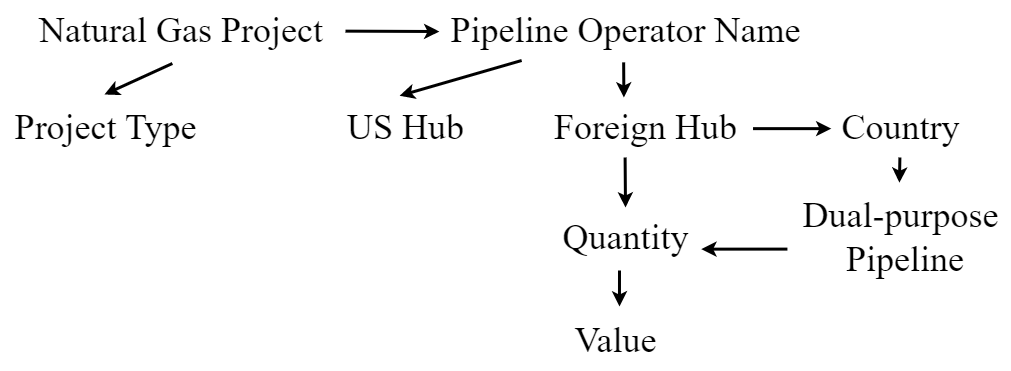

In [2]:
Image('HW3Q1.png')

1) Which of the following conditional independence relationships hold? Choose “Independent” or “Dependent” for each (6 points):

CI (Natural Gas Project, Value | Foreign Hub)?  

CI (Natural Gas Project, Value | Pipeline Operator Name)?  

CI (Foreign Hub, Dual-Purpose Pipeline | Country)? 

CI (Foreign Hub, Dual-Purpose Pipeline | County, Value)? 

2) Now consider a smaller dataset with four discrete attributes (Pipeline Operator, US Hub, Foreign Hub, Quantity) as in as in HW3Q1_2.png, and the following conditional probability distributions:

Pipeline Operator: YHVA (70%), PLMG (30%)

Foreign Hub | Pipeline Operator Name = YHVA: Mexico Northeast Region (40%), Mexico Central Region (60%)

Foreign Hub | Pipeline Operator Name = PLMG: Mexico Northeast Region (100%)

US Hub | Pipeline Operator Name = PLMG: US Hub (100%)

US Hub | Pipeline Operator Name = YHVA: US Hub (100%)

Quantity | Pipeline Operator Name = YHVA, Foreign Hub = Mexico Northeast Region: Natural Gas (95%), Hydrogen (5%)

Quantity | Pipeline Operator Name = PLMG, Foreign Hub = Mexico Northeast Region: Natural Gas (98%), Hydrogen (2%)

Quantity | Pipeline Operator Name = YHVA, Foreign Hub = Mexico Central Region: Natural Gas (96%), Hydrogen (4%)

Which of the following cases is most anomalous?

a) Natural gas transported from the Mexico Northeast Region to a US Hub by PLMG

b) Natural gas transported from the Mexico Northeast Region to a US Hub by YHVA

c) Hydrogen trasported from the Mexico Central Region to a US Hub by YHVA

To answer this question, compute the likelihood of each fuel (natural gas and hydrogen) given the Bayesian Network (lowest likelihood = most anomalous). You must show your calculations to receive credit. (9 points)

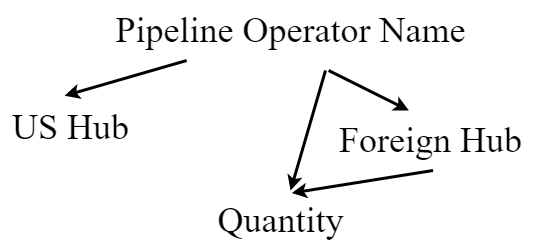

In [3]:
Image('HW3Q1_2.png')

(Your answers here, including all calculations)

### Q2. Bayesian Network Learning (35 points)

In this question, we use dataset: "HW3Q2.csv" for Bayesian Network Learning.

In [ ]:
# You will need to install pgmpy
from sklearn.model_selection import train_test_split
data2=pd.read_csv("HW3Q2.csv")
train,test=train_test_split(data2,random_state=9,test_size=0.4)
data2.head()

a) Use the training data to select the best structure you want to use for Bayesian Network Learning. Please use Hill Climbing with BIC score metric. (10 points)

b) Use the Bayesian Estimator to estimate the CPDs for your model and visualize the network with CPDs. (15 points)

c) Use the model to predict "A" for the testing dataset. Report the out-of-sample prediction accuracy. (10 points)   

In [ ]:
# your answers here

### Q3. Clustering: Spatial and Temporal Distributions of Chicago Crimes (50 points+20 bonus points)

In this question you will use k-means and Gaussian mixture clustering in sklearn and hierarchical clustering in scipy to answer the question, “Do different types of crime display different trends over space and time?”  The dataset “HW3Q3_1.csv” consists of data for 119 different types of crime, each of which occurred at least 100 times in Chicago during the year 2016.  For each crime type, we have various features representing the spatial and temporal distribution of crime, including:

- The proportion of all crimes of that type that occurred on each day of the week (day_Sun, day_Mon, …, day_Sat).

- The proportion of all crimes of that type that occurred on each hour of the day (hour_0 = midnight to 12:59am, hour_1 = 1am to 1:59am, …, hour_23 = 11pm to 11:59pm).

- The proportion of all crime of that type that occurred in each of the 77 community areas of Chicago (community_area_1 … community_area_77).

We also have, for each crime type, its categorization by the FBI:

- Category = “P1V” corresponds to Part 1 Violent Crime, i.e., serious violent crimes

- Category = “P1P” corresponds to Part 1 Property Crime, i.e., serious property crimes

- Category = “P2” corresponds to Part 2 (less serious) crimes.

To answer parts a through f, you should cluster the 119 crime types using k-means into k = 3 clusters using only the hour of day (hour_0..hour_23) attributes.

a) Copy each cluster’s mean values for hour_0…hour_23 into a DataFrame and create a line graph to visualize these values by cluster.  (5 pts)

b) Describe the three different hour-of-day trends represented by these three clusters (10 pts).

c) **(Bonus)** Do you notice any consistent trends about which crime types are assigned to which cluster?  Note that by a "crime type", we are referring to specific crimes such as "narcotics" or "assault", not the FBI categories. (10 pts)  

d) **(Bonus)** Do the three clusters have different day-of-week trends?  Again, visualize the trends for each cluster by creating a line graph and discuss any notable differences.  (10 pts)

e) Do the three clusters affect different types of communities/neighborhoods?  To answer this question, you could first compute the proportions of "cluster 1", "cluster 2", and "cluster 3" crimes for each community area, and identify particular community areas with disproportionate amounts of a given cluster.  You can then use the provided file (HW3Q3_2.csv), to determine whether these community areas have any notable common characteristics (poverty, overcrowding, etc.).  You may also wish to consult the Chicago Community Areas map at https://en.wikipedia.org/wiki/Community_areas_in_Chicago. (10 pts)

f) How well do the three groups formed by clustering hour-of-day trends correspond to the FBI’s division between P1V, P1P, and P2 crimes? (5 pts)

g) For part g, you will use the same dataset to compare the clusters produced by several different methods.  But this time you should cluster using only the _day-of-week_ (not hour-of-day) attributes (day_Sun..day_Sat).  Please perform four different clusterings using (i) k-means, (ii) Gaussian mixture models, (iii) Bottom-up hierarchical clustering with "single link" distance metric, and (iv) Bottom-up hierarchical clustering with "complete link" distance metric.  In each case, you should choose the number of clusters using the silhouette method (or another established method of your choice- please specify).  For each clustering, report the number of clusters formed and the number of elements in each cluster. You should also identify any notable similarities or differences between the clusterings. (20 pts)


In [ ]:
data3=pd.read_csv("HW3Q3_1.csv")
data3.head()

In [ ]:
data4=pd.read_csv("HW3Q3_2.csv")
data4.head()

In [ ]:
# your answers here